<a href="https://colab.research.google.com/github/PHMark/ML-Personal-Projects/blob/master/Amazon_Food_Reviews_Sentiment_Analysis/Amazon_Fine_Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Amazon Food Reviews Analysis </h1>

# 1. Overview

## 1.1 Data Overview

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

<b>Attribute Information: </b>


<table>
  <tr>
    <th>Attribute Name</th>
    <th>Information</th>
  </tr>
  <tr>
    <td>Id </td>
  </tr>
  <tr>
    <td>ProductId</td>
    <td>Unique identifier for the product</td>
  </tr> 
  <tr>
    <td>UserId</td> 
    <td>Unqiue identifier for the user</td>
  </tr>
  <tr>
    <td>ProfileName</td>
    <td></td>
  </tr>
  <tr>
    <td>HelpfulnessNumerator</td>
    <td>Number of users who found the 
    review helpful</td>
  </tr>
  <tr>
    <td>HelpfulnessDenominator</td>
    <td>Number of users who indicated whether they found the review helpful or not</td>
  </tr>
  <tr>
    <td>Score</td>
    <td>Rating between 1 and 5</td>
  </tr>
  <tr>
    <td>Time</td>
    <td>Timestamp for the review</td>
  </tr>
  <tr>
    <td>Summary</td>
    <td>Brief summary of the review</td>
  </tr>
  <tr>
    <td>Text</td>
    <td>Text of the review</td>
  </tr>
</table>


## 1.2 Real World / Business Objectives and Constraints


*  Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

# 2. Machine Learning Problem

## 2.1 Mapping the real-world problem to a Machine Learning Problem

### 2.1.1 Type of Machine Learning Problem

<p> It is a binary classification problem</p>

*  Given a review, we are going to predict whether it is a positive review or a negative review.



### 2.1.2 Performance metric

<b>F1-Score (F-Score or F-measure): </b> <br>
*  The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

```
F1 = 2 * (precision * recall) / (precision + recall)
```


<br>
<b> ROC AUC Score: </b><br>

*  Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
*  A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.

<br>
<b>Source(s):</b> <br>

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

# 3. Exploratory Data Analysis

In [ ]:
import re
import sqlite3

# Misc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from prettytable import PrettyTable

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

try:
  STOPWORDS = set(stopwords.words())
except:  
  nltk.download('stopwords')
  STOPWORDS = set(stopwords.words())

STOPWORDS.remove('not')

DATA_DIR = 'drive/My Drive/ML Projects/Amazon Fine Food Reviews/data'
INPUT_DIR = DATA_DIR + '/input/'
pd.set_option('display.max_columns', 15)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Create a database connection instance
con = sqlite3.connect(INPUT_DIR + 'amazon_food_reviews_database.sqlite')

In [ ]:
df = pd.read_sql('SELECT * FROM reviews WHERE 1', con=con)

## 3.1 High Level Statistics

### 3.1.1 What is the dimension of our dataset?

In [ ]:
print('Total number of rows: {}'.format(df.shape[0]))
print('Total number of columns: {}'.format(df.shape[1]))

Total number of rows: 568454
Total number of columns: 10


### 3.1.2 What does the data looks like?

In [ ]:
df.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
87378,87379,B007POA2L6,A2PVIEX4VNELTR,"Linda Navas ""Linda Becker""",0,0,1,1350345600,Complete waste!,Too pricy for what you get. I was expecting so...
477633,477634,B0001M0YK8,A23UBV7X88P3BI,"P. G., Ed",5,8,5,1189900800,Cream of Tarter,"The purchase went smoothly, price was good, an..."
533890,533891,B003S6ONQA,A3SLQYSM4VEKSX,jrsposter,0,0,5,1324080000,Mini Moo's taste great,I really like this coffee creamer. It does no...
510690,510691,B004IRGD3O,A2S4DN72TMWC2C,"Andy M. ""techno-geek""",0,0,2,1347321600,Meh,This review pertains to the Black Silk only. I...
220251,220252,B0034EDLS2,A1DB2KAGYSO774,mommy of 2,0,0,5,1346284800,YUM,"They are very tasty.If you like coconut, you c..."


In [ ]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


### 3.1.3 Are there Null Values in the dataset?

In [ ]:
df.isna().sum() / df.shape[0]*100

Id                        0.0
ProductId                 0.0
UserId                    0.0
ProfileName               0.0
HelpfulnessNumerator      0.0
HelpfulnessDenominator    0.0
Score                     0.0
Time                      0.0
Summary                   0.0
Text                      0.0
dtype: float64

### 3.1.4 What type of variables do we have?

In [ ]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

### 3.1.5 Do we have duplicate reviews in the dataset?

In [ ]:
dup_counts = df[['UserId', 'ProfileName', 'Time', 'Text']].duplicated().sum()
print('Percentage of Duplicate Reviews:', str(round(dup_counts/df.shape[0]*100, 2))+'%')

Percentage of Duplicate Reviews: 30.7%


In [ ]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]

### 3.1.6 What is the distribution of the Score variable?

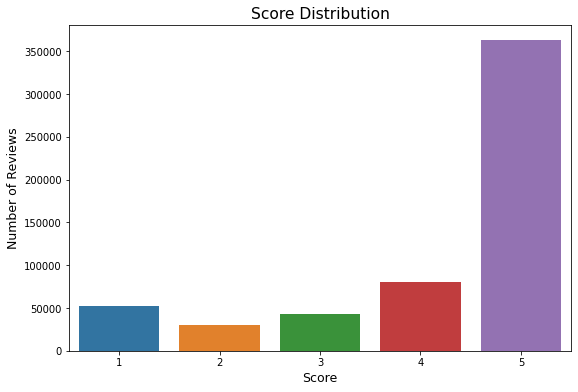

In [ ]:
plt.figure(figsize=(9,6))
plt.title('Score Distribution', fontsize=15.5)
sns.barplot(x=df['Score'].value_counts().index, 
            y=df['Score'].value_counts().values)
plt.xlabel('Score', fontsize=12.5)
plt.ylabel('Number of Reviews', fontsize=12.5)
plt.show()

### 3.1.7 What is the Distribution of the Score Variable w.r.t the Frequency of Reviewer?


In [ ]:
def get_freq_bin(value):
  if value < 50 and value > 0:
    return 'Not Frequent (1-50 reviews)'
  elif value >= 50:
    return 'Frequent (> 50 reviews)'

In [ ]:
query = '''SELECT UserId,
                  Score,
                  COUNT(DISTINCT ProductId) AS ProductsReviewed
          FROM reviews
          GROUP BY UserId, Score
        '''
freq_df = pd.read_sql(query, con=con)
freq_df['Frequency Of Reviewer'] = freq_df['ProductsReviewed'].apply(get_freq_bin)

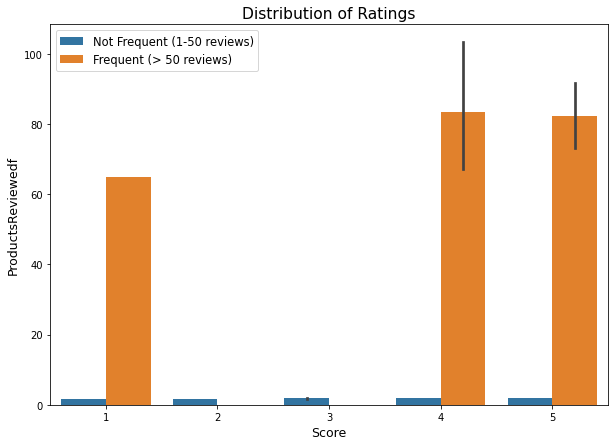

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Distribution of Ratings', fontsize=15.5)
sns.barplot(x='Score', y='ProductsReviewed', hue='Frequency Of Reviewer', data=freq_df)
plt.xlabel('Score', fontsize=12.5)
plt.ylabel('ProductsReviewedf', fontsize=12.5)
plt.legend(fontsize=11.5)
plt.show()

### 3.1.8 What is the distribution of Helpfulness?

In [ ]:
df['HelpfulPerc'] = (df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']) * 100
df.loc[df['HelpfulPerc'].isna(), 'HelpfulPerc'] = -1

In [ ]:
def map_helpfulness(value):
  if value == -1:
    return 'No Indication'
  elif value >= 75:
    return '> 75%'
  elif value > 25 and value < 75:
    return '25 - 75%'
  elif value > -1 and value <= 25:
    return '< 25%'

In [ ]:
helpful_dist_df = pd.DataFrame((df['HelpfulPerc'].value_counts()).T.reset_index())
helpful_dist_df.columns = ['values', 'percent']
helpful_dist_df['helpful_ind'] = helpful_dist_df['values'].apply(map_helpfulness)
helpful_dist = (helpful_dist_df.groupby('helpful_ind').sum() / df.shape[0]*100).reset_index()
helpful_dist.drop('values', axis=1, inplace=True)

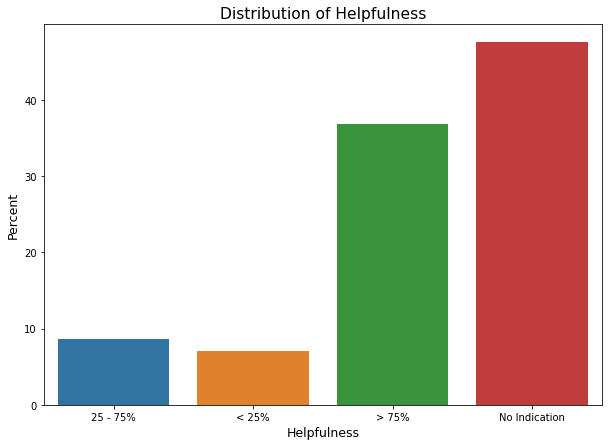

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Distribution of Helpfulness', fontsize=15.5)
sns.barplot(x='helpful_ind', y='percent', data=helpful_dist)
plt.ylabel('Percent', fontsize=12.5)
plt.xlabel('Helpfulness', fontsize=12.5)
plt.show()

### 3.1.9 What is the distribution of Helpfulness w.r.t Score?

In [ ]:
df['HelpfulPerc_Indicator'] = df['HelpfulPerc'].apply(map_helpfulness)

In [ ]:
helpfulness_df = df[df['HelpfulPerc_Indicator'].isin(['> 75%', '< 25%'])].groupby(['HelpfulPerc_Indicator', 'Score']).count()['HelpfulPerc'].reset_index()
helpfulness_df = pd.merge(helpfulness_df, helpful_dist_df.groupby('helpful_ind').sum().reset_index(), right_on='helpful_ind', left_on='HelpfulPerc_Indicator')
helpfulness_df['HelpfulPerc'] = helpfulness_df['HelpfulPerc']/df.shape[0]*100
helpfulness_df['HelpfulPerc_Indicator'] = helpfulness_df['HelpfulPerc_Indicator'].apply(lambda x: 'Unhelpful [ ' + x + ' ]' if x=='< 25%'  else 'Helpful [ ' + x + ' ]')

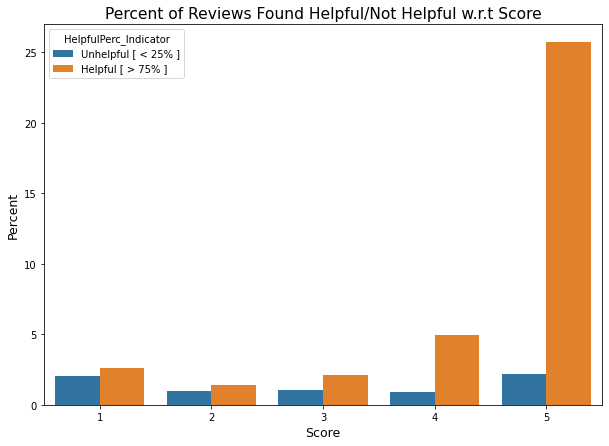

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Percent of Reviews Found Helpful/Not Helpful w.r.t Score', fontsize=15.5)
sns.barplot(x='Score', y='HelpfulPerc', data=helpfulness_df, hue='HelpfulPerc_Indicator')
plt.ylabel('Percent', fontsize=12.5)
plt.xlabel('Score', fontsize=12.5)
plt.show()

<b> Observation(s): </b>

*  There are 568,454 datapoints and 69.3% of them are unique.
*  We have 5 categorical variables and 5 numerical variables
*  There are no null values in the dataset.
*  The target variable is skewed. This implies that our dataset is suffering from class imbalance issue

## 3.2 Basic Data Preprocessing

The dataset is pretty much clean, however, we still need to perform the following:

1. Data Deduplication

2. Remove unnecessary columns

3. Converting the target variable into a binary categorical variable

Here, I will remove the columns: Id, UserId, ProfileName, & Time

In [ ]:
# Deduplication
primary_columns = ['UserId', 'ProfileName', 'Time', 'Text']
columns_of_int = ['ProductId', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
                  'Time', 'Summary', 'Text', 'Score']
temp_df = df[~df[primary_columns].duplicated()].copy()

# Remove unnecessary columns
temp_df = temp_df[columns_of_int]

# Binarize target variable
temp_df = temp_df[temp_df['Score'] != 3]
temp_df['Score'] = temp_df['Score'].apply(lambda x: 0 if x in [1,2] else 1)

In [ ]:
print('Number of rows after preprocessing:', temp_df.shape[0])
print('Number of columns after preprocessing:', temp_df.shape[1])

Number of rows after preprocessing: 364162
Number of columns after preprocessing: 7


## 3.3 Text Preprocessing

In [ ]:
def remove_html_tags(string):
  return re.sub('<.+?>', ' ', string).strip()

def remove_url(string):
  return re.sub('http\S+', ' ', string).strip()

def to_lower(string):
  return string.lower()

def remove_special_characters(string):
  return re.sub('[^A-Za-z0-9]+', ' ', string).strip()

def decontracted(string):
    # https://stackoverflow.com/a/47091490/4084039

    # specific
    phrase = re.sub(r"won't", "will not", string)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_words_with_numbers(string):
  return re.sub('\S*\d\S*', '', string).strip()

def remove_stopwords(string):
  return ' '.join([i for i in string.split() if i not in STOPWORDS])

def preprocess_text(string):
  string = to_lower(string)
  string = remove_html_tags(string)
  string = remove_url(string)
  string = remove_special_characters(string)
  string = decontracted(string)
  string = remove_words_with_numbers(string)
  string = remove_stopwords(string)
  return string.strip()

In [ ]:
tqdm.pandas()
temp_df['Text'] = temp_df['Text'].progress_apply(preprocess_text)
temp_df['Summary'] = temp_df['Summary'].progress_apply(preprocess_text)

100%|██████████| 364162/364162 [00:06<00:00, 52264.12it/s]


### 3.3.1 Train and Test set splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(temp_df[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Text', 'Summary']], temp_df['Score'], 
                                                    stratify=temp_df['Score'], test_size=0.3, random_state=99)

## 3.4 Text Analysis

In [ ]:
text_grams = {}
summary_grams = {}
positive_filt = y_train == 1
negative_filt = y_train == 0
pos_text = {}
pos_summary = {}
neg_text = {}
neg_summary = {}

for n in (1, 2):
  # Text
  vectorizer = CountVectorizer(ngram_range=(n,n))
  vectorizer.fit(X_train.loc[positive_filt, 'Text'])
  text_grams['pos_{}_grams'.format(n)] = vectorizer.transform(X_train.loc[positive_filt, 'Text'])
  pos_text['names_{}'.format(n)] = vectorizer.get_feature_names()
  pos_text['freq_{}'.format(n)]= text_grams['pos_{}_grams'.format(n)].sum(axis=0).A1

  vectorizer = CountVectorizer(ngram_range=(n,n))
  vectorizer.fit(X_train.loc[negative_filt, 'Text'])
  text_grams['neg_{}_grams'.format(n)] = vectorizer.transform(X_train.loc[negative_filt, 'Text'])
  neg_text['names_{}'.format(n)] = vectorizer.get_feature_names()
  neg_text['freq_{}'.format(n)] = text_grams['neg_{}_grams'.format(n)].sum(axis=0).A1 

  # Summary
  vectorizer = CountVectorizer(ngram_range=(n,n))
  vectorizer.fit(X_train.loc[positive_filt, 'Summary'])
  summary_grams['pos_{}_grams'.format(n)] = vectorizer.transform(X_train.loc[positive_filt, 'Summary'])
  pos_summary['names_{}'.format(n)] = vectorizer.get_feature_names()
  pos_summary['freq_{}'.format(n)] = summary_grams['pos_{}_grams'.format(n)].sum(axis=0).A1 

  vectorizer = CountVectorizer(ngram_range=(n,n))
  vectorizer.fit(X_train.loc[negative_filt, 'Summary'])
  summary_grams['neg_{}_grams'.format(n)] = vectorizer.transform(X_train.loc[negative_filt, 'Summary'])
  neg_summary['names_{}'.format(n)] = vectorizer.get_feature_names()
  neg_summary['freq_{}'.format(n)] = summary_grams['neg_{}_grams'.format(n)].sum(axis=0).A1 

In [ ]:
# Check if we have the keys that we need
print(pos_text.keys())
print(neg_text.keys())
print(pos_summary.keys())
print(neg_summary.keys())

dict_keys(['names_1', 'freq_1', 'names_2', 'freq_2'])
dict_keys(['names_1', 'freq_1', 'names_2', 'freq_2'])
dict_keys(['names_1', 'freq_1', 'names_2', 'freq_2'])
dict_keys(['names_1', 'freq_1', 'names_2', 'freq_2'])


### 3.4.1 Unigrams

In [ ]:
def plot_wordcloud(dictionary):
  wordcloud = WordCloud(background_color='grey', width=640,
                        height=480) \
              .generate_from_frequencies(dictionary)
  plt.figure(figsize=(30, 10))
  plt.imshow(wordcloud)
  plt.axis(False)
  plt.show()

#### 3.4.1.1 Text Column

Most Common Positive Words

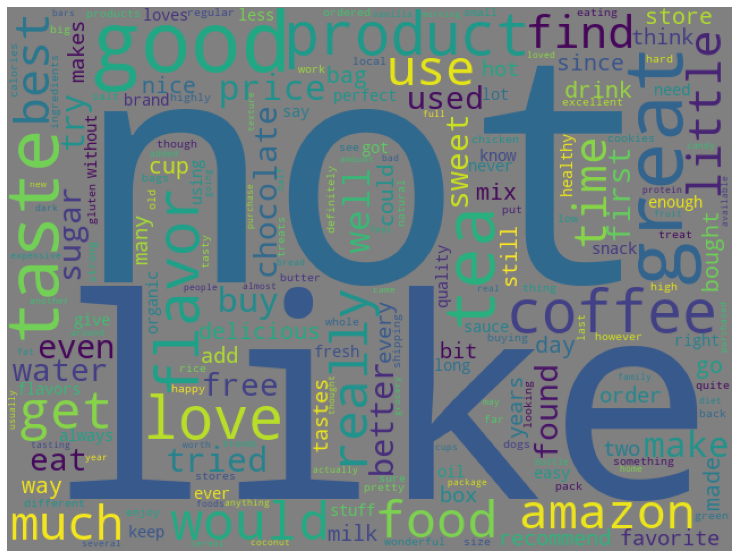

In [ ]:
plot_wordcloud(dict(zip(pos_text['names_1'], pos_text['freq_1'])))

Most Common Negative Words

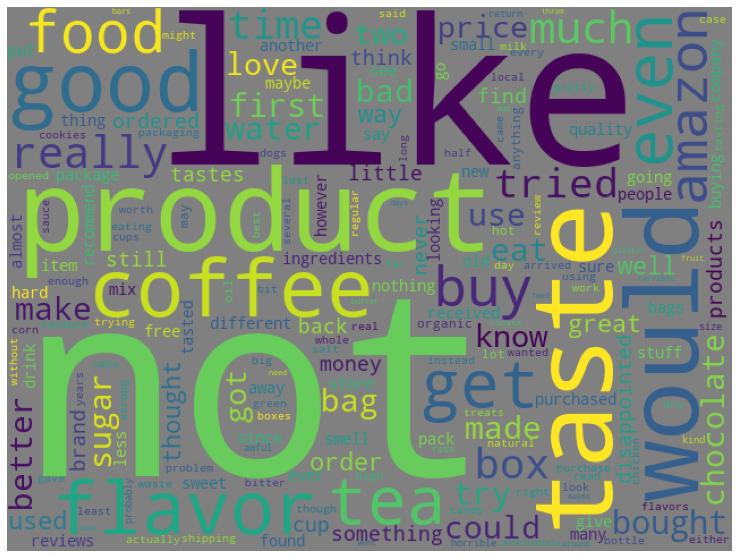

In [ ]:
plot_wordcloud(dict(zip(neg_text['names_1'], neg_text['freq_1'])))

#### 3.4.1.2 Summary Column

Most Common Positive Words

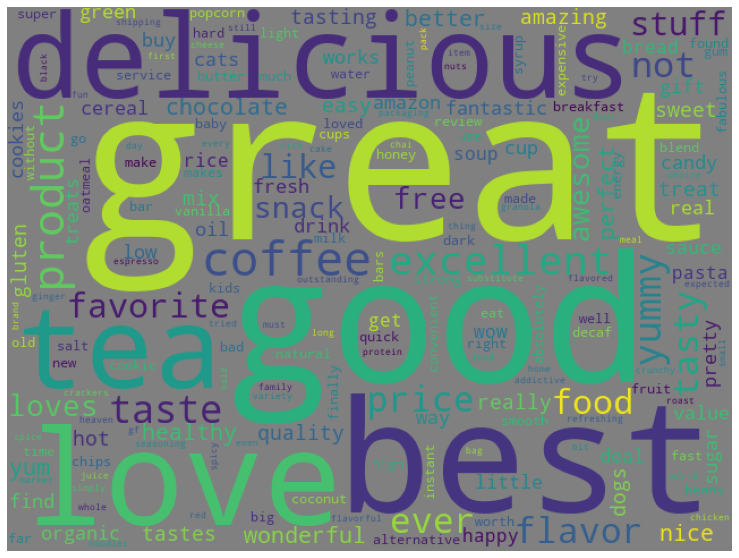

In [ ]:
plot_wordcloud(dict(zip(pos_summary['names_1'], pos_summary['freq_1'])))

Most Common Negative Words

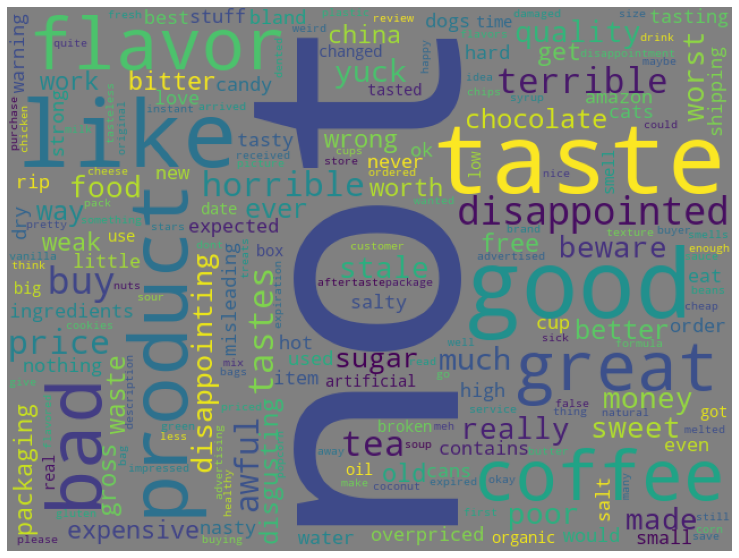

In [ ]:
plot_wordcloud(dict(zip(neg_summary['names_1'], neg_summary['freq_1'])))

### 3.4.2 Bigrams

#### 3.4.2.1 Text Column

In [ ]:
def plot_bigrams(dictionary):
  temp_series = pd.Series(dictionary)
  temp_series = temp_series.sort_values(ascending=False).head(15)
  plt.figure(figsize=(9, 5))
  sns.barplot(x=temp_series.values, y=temp_series.index)
  plt.show()

Most Common Positive Words

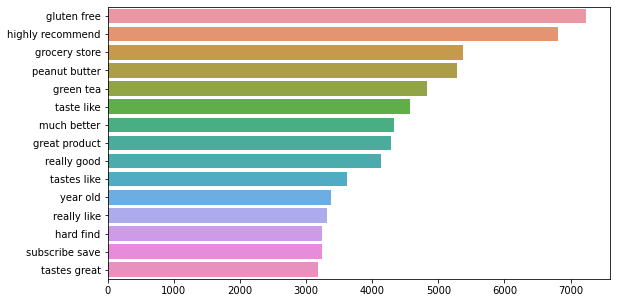

In [ ]:
plot_bigrams(dict(zip(pos_text['names_2'], pos_text['freq_2'])))

Most Common Negative Words

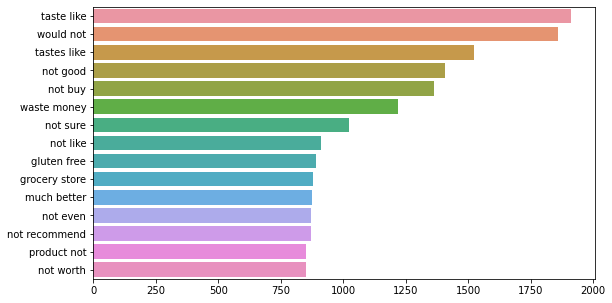

In [ ]:
plot_bigrams(dict(zip(neg_text['names_2'], neg_text['freq_2'])))

#### 3.4.2.2 Summary Column

Most Common Positive Words

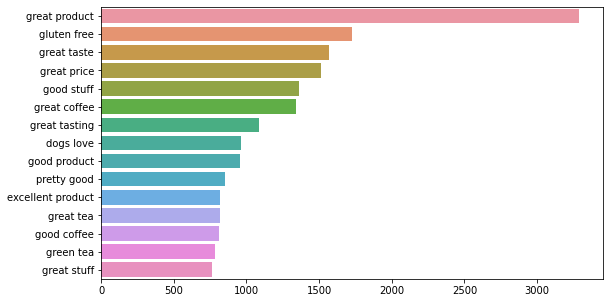

In [ ]:
plot_bigrams(dict(zip(pos_summary['names_2'], pos_summary['freq_2'])))

<b> Most Common Negative Words [Summary]</b>

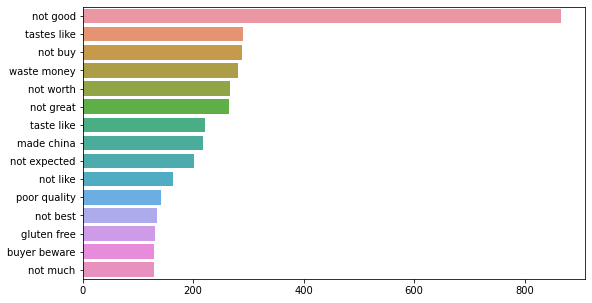

In [ ]:
plot_bigrams(dict(zip(neg_summary['names_2'], neg_summary['freq_2'])))

### 3.4.3 Word Count

In [ ]:
df['Text_Summary'] = df['Text'] + ' ' + df['Summary']

In [ ]:
word_count = df[['Text_Summary', 'Score', 'HelpfulPerc']].copy()
word_count['Count'] = np.log10(word_count['Text_Summary'].apply(lambda x: len([i for i in x.split() if i not in STOPWORDS])))
word_count['Helpful_Indicator'] = word_count['HelpfulPerc'].apply(lambda x: 'Helpful' if x >= 0.75 else 'Not Helpful')

#### 3.4.3.1 Word Count by Score

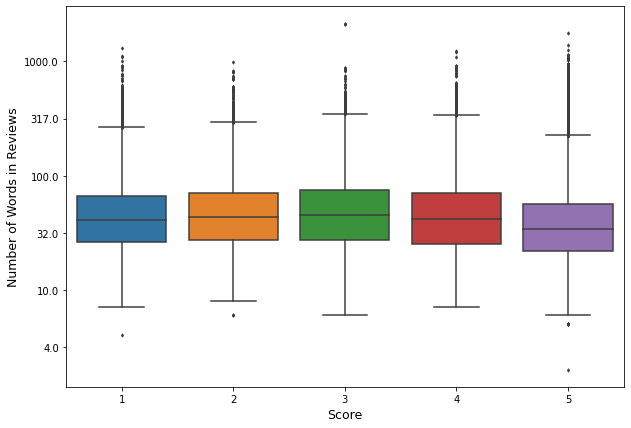

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Score', y='Count', data=word_count, fliersize=2.25)
ticks = [0.5, 1, 1.5, 2, 2.5, 3]
plt.yticks(ticks=ticks, labels=map(str, list(map(lambda x: np.ceil(10**x), ticks))))
plt.ylabel('Number of Words in Reviews', fontsize=12.5)
plt.xlabel('Score', fontsize=12.5)
plt.show()

#### 3.4.3.2 Word Count by Helpfulness

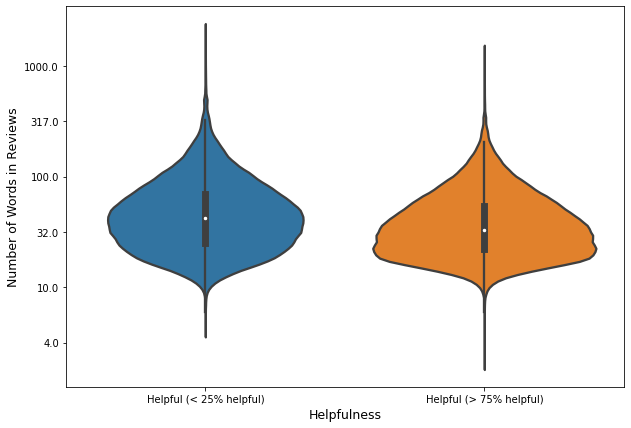

In [ ]:
plt.figure(figsize=(10, 7))
sns.violinplot(x='Helpful_Indicator', y='Count', data=word_count, linewidth=2.3)
ticks = [0.5, 1, 1.5, 2, 2.5, 3]
plt.yticks(ticks=ticks, labels=map(str, list(map(lambda x: np.ceil(10**x), ticks))))
plt.ylabel('Number of Words in Reviews', fontsize=12.5)
plt.xlabel('Helpfulness', fontsize=12.5)
plt.xticks([1, 0], ['Helpful (> 75% helpful)', 'Helpful (< 25% helpful)'])
plt.show()

# 4. Machine Learning Modeling

## 4.1 TFIDF

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)

In [ ]:
temp_df = temp_df.sort_values(by=['Time'], ascending=False)
finalDataPoints = temp_df.head(100000)
feature_of_int = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Text', 'Summary']

### 4.1.2 Time Based Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(finalDataPoints[feature_of_int], 
                                                    finalDataPoints['Score'], 
                                                    shuffle=False, test_size=0.2)

In [ ]:
X_train['Text_Summary'] = X_train['Text'] + ' ' + ((X_train['Summary'] + ' ') * 5)
X_train['Text_Summary'] = X_train['Text_Summary'].str.strip()

In [ ]:
X_test['Text_Summary'] = X_test['Text'] + ' ' + ((X_test['Summary'] + ' ') * 5)
X_test['Text_Summary'] = X_test['Text_Summary'].str.strip()

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train['Text_Summary'])
X_test_tfidf = tfidf.transform(X_test['Text_Summary'])

In [ ]:
X_train_tfidf.get_shape()

(80000, 1410132)

### 4.1.1 Linear SVM

In [ ]:
svm_score_train = {'roc': [], 'f1': []}
svm_score_cv = {'roc': [], 'f1': []}

a_val = [0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

for a in tqdm(a_val):
  clf = SGDClassifier(loss='hinge', alpha=a, class_weight='balanced', 
                      learning_rate='optimal', eta0=0.001, n_jobs=2, 
                      random_state=99) 
  clf.fit(X_train_tfidf, y_train)
  calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
  calib_clf.fit(X_train_tfidf, y_train)

  predicted_y_test = calib_clf.predict_proba(X_test_tfidf)
  predicted_y_train = calib_clf.predict_proba(X_train_tfidf)

  probs_test = predicted_y_test[:, 1]
  probs_train = predicted_y_train[:, 1]

  svm_score_train['roc'].append(roc_auc_score(y_train, probs_train))
  svm_score_train['f1'].append(f1_score(y_train, calib_clf.predict(X_train_tfidf), average='weighted'))

  svm_score_cv['roc'].append(roc_auc_score(y_test, probs_test))
  svm_score_cv['f1'].append(f1_score(y_test, calib_clf.predict(X_test_tfidf), average='weighted'))

100%|██████████| 13/13 [01:04<00:00,  4.96s/it]


#### Error Plots

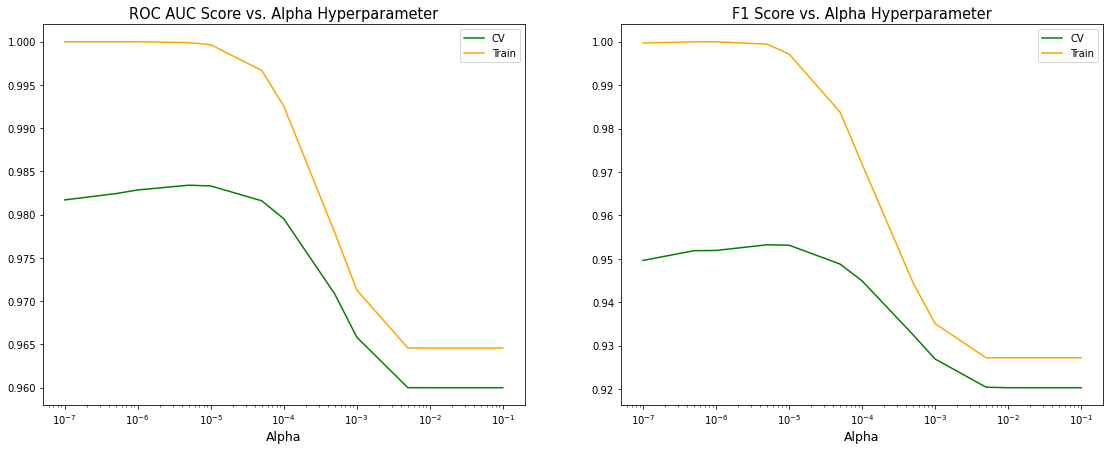

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(19, 7))
axes[0].set_title('ROC AUC Score vs. Alpha Hyperparameter', fontsize=14.5)
axes[0].plot(a_val, svm_score_cv['roc'], color='green', label='CV')
axes[0].plot(a_val, svm_score_train['roc'], color='orange', label='Train')
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha', fontsize=12.5)
axes[0].legend()

axes[1].set_title('F1 Score vs. Alpha Hyperparameter', fontsize=14.5)
axes[1].plot(a_val, svm_score_cv['f1'], color='green', label='CV')
axes[1].plot(a_val, svm_score_train['f1'], color='orange', label='Train')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha', fontsize=12.5)
axes[1].legend()

fig.show()

#### Training SVM using the Optimum Hyperparameter

In [ ]:
opt_svm = SGDClassifier(loss='hinge', alpha=a_val[8], class_weight='balanced', 
                        learning_rate='optimal', eta0=0.001, n_jobs=2, random_state=99) 
opt_svm.fit(X_train_tfidf, y_train)
opt_svm_calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
opt_svm_calib_clf.fit(X_train_tfidf, y_train)
svm_predictions_proba = opt_svm_calib_clf.predict_proba(X_test_tfidf)[:, 1]
svm_predictions = opt_svm_calib_clf.predict(X_test_tfidf)

#### Confusion Matrix

In [ ]:
opt_svm_cm = confusion_matrix(y_test, svm_predictions)

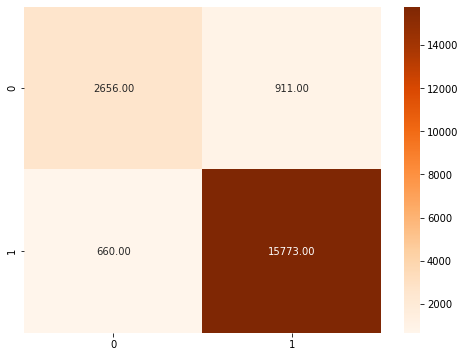

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(opt_svm_cm, annot=True, fmt='0.2f', cmap='Oranges')
plt.show()

#### Will SVM improve if we add more Training data?

In [ ]:
kf = KFold(n_splits=5)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(opt_svm, X_train_tfidf, y_train, train_sizes=np.linspace(.1, 1.0, 10),
                                                                      cv=kf, scoring='f1', random_state=99, return_times=True)

In [ ]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=15.5)

    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples", fontsize=12.5)
    plt.ylabel("Score", fontsize=12.5)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

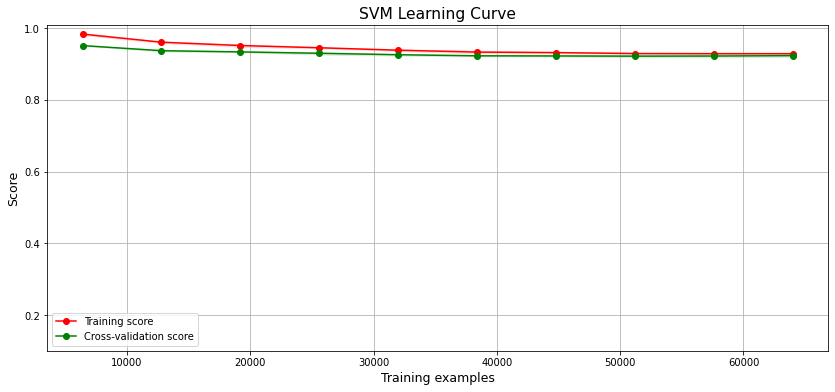

In [ ]:
plot_learning_curve(train_sizes, train_scores, test_scores, ylim=(0.1, 1.01),
                    title='SVM Learning Curve', figsize=(14,6))

### 4.2.1 Logistic Regression

In [ ]:
lr_score_train = {'roc': [], 'f1': []}
lr_score_cv = {'roc': [], 'f1': []}

C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

clf = LogisticRegression(class_weight='balanced', n_jobs=2, 
                         random_state=99)
lr_grid_cv = GridSearchCV(clf, C_value, scoring='f1', cv=kf, return_train_score=True)
lr_grid_cv.fit(X_train_tfidf, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=2, penalty='l2',
                                          random_state=99, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)

#### Error Plots

In [ ]:
lr_score_train = lr_grid_cv.cv_results_['mean_train_score']
lr_score_cv = lr_grid_cv.cv_results_['mean_test_score']

In [ ]:
lr_best_C = C_value[0]['C'][4]

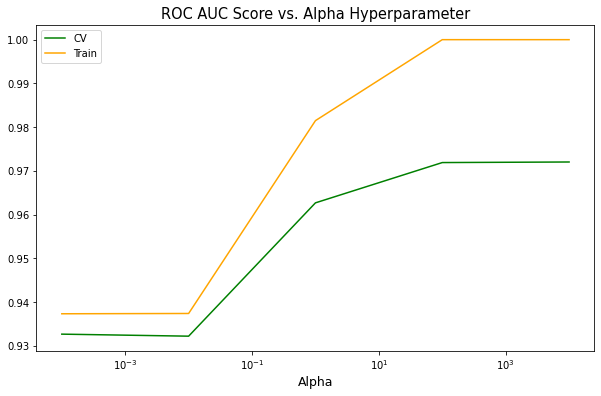

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.title('ROC AUC Score vs. Alpha Hyperparameter', fontsize=14.5)
plt.plot(C_value[0]['C'], lr_score_cv, color='green', label='CV')
plt.plot(C_value[0]['C'], lr_score_train, color='orange', label='Train')
plt.xscale('log')
plt.xlabel('Alpha', fontsize=12.5)
plt.legend()

fig.show()

#### Training Logistic Regression using the Optimum Hyperparameter

In [ ]:
opt_lr = LogisticRegression(class_weight='balanced', n_jobs=2, 
                         random_state=99, C=lr_best_C)
opt_lr.fit(X_train_tfidf, y_train)
lr_predictions_proba = opt_lr.predict_proba(X_test_tfidf)[:, 1]
lr_predictions = opt_lr.predict(X_test_tfidf)

#### Confusion Matrix

In [ ]:
opt_lr_cm = confusion_matrix(y_test, lr_predictions)

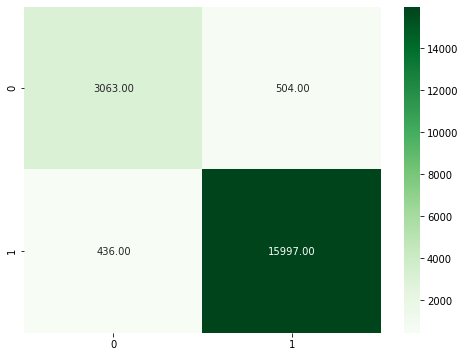

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(opt_lr_cm, annot=True, fmt='0.2f', cmap='Greens')
plt.show()

#### Will Logistic Regression improve if we add more Training data?

In [ ]:
kf = KFold(n_splits=5)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(opt_lr, X_train_tfidf, y_train, train_sizes=np.linspace(.1, 1.0, 10),
                                                                      cv=kf, scoring='f1', random_state=99, return_times=True)

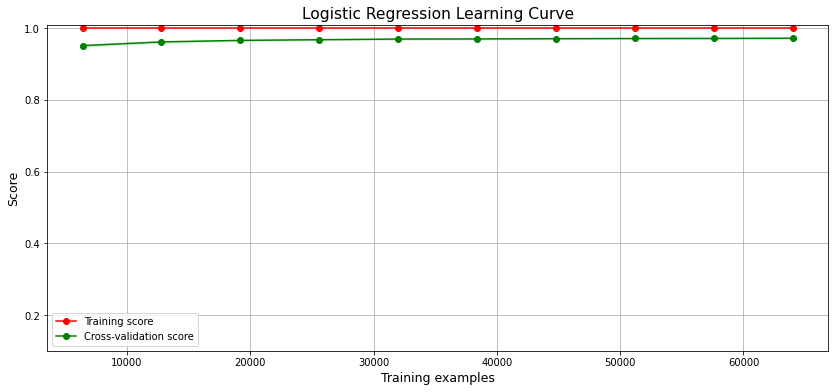

In [ ]:
plot_learning_curve(train_sizes, train_scores, test_scores, ylim=(0.1, 1.01),
                    title='Logistic Regression Learning Curve', figsize=(14,6))

#### Can we improve the model's speed/score by performing Feature Selection?

In [ ]:
def get_best_C():
  kf = KFold(n_splits=5)
  C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
  clf = LogisticRegression(class_weight='balanced', n_jobs=3, 
                          random_state=99, penalty='l1', solver='liblinear')
  lr_grid_cv = GridSearchCV(clf, C_value, scoring='f1', cv=kf, 
                            return_train_score=True, verbose=3)
  lr_grid_cv.fit(X_train_tfidf, y_train)
  return lr_grid_cv.best_params_['C']

##### Selecting Features using L1 Regularization

In [ ]:
lr_best_C = get_best_C()
sel_ = SelectFromModel(LogisticRegression(class_weight='balanced', n_jobs=3, 
                       random_state=99, penalty='l1', solver='liblinear', 
                       C=lr_best_C))
sel_.fit(X_train_tfidf, y_train)
feature_set = (np.abs(sel_.estimator_.coef_) > np.abs(sel_.estimator_.coef_).mean()).ravel()

In [ ]:
features_selected = X_train_tfidf[:, feature_set]
test_features = X_test_tfidf[:, feature_set]

##### Tuning the Hyperparameter using the Selected Features

In [ ]:
lr_score_train = {'roc': [], 'f1': []}
lr_score_cv = {'roc': [], 'f1': []}
kf = KFold(n_splits=5)

C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

clf = LogisticRegression(class_weight='balanced', n_jobs=3, 
                         random_state=99, penalty='l1', solver='liblinear')
lr_grid_cv = GridSearchCV(clf, C_value, scoring='f1', cv=kf, 
                          return_train_score=True, verbose=3)
lr_grid_cv.fit(features_selected, y_train)

##### Train and Evaluation Time Complexity

In [ ]:
mean_fit_time = lr_grid_cv.cv_results_['mean_fit_time']
mean_score_time = lr_grid_cv.cv_results_['mean_score_time']
mean_test_score = lr_grid_cv.cv_results_['mean_test_score']
mean_train_score = lr_grid_cv.cv_results_['mean_train_score']

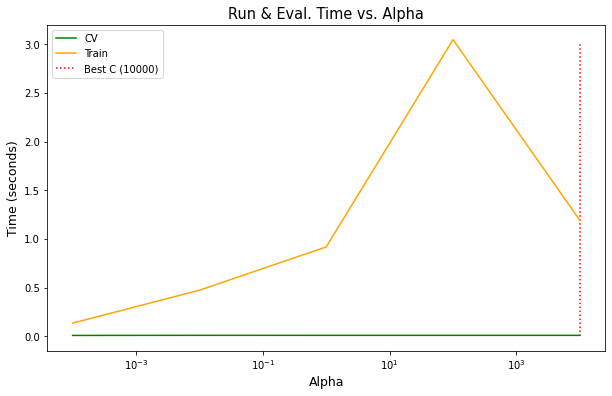

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.title('Run & Eval. Time vs. Alpha', fontsize=14.5)
plt.plot(C_value[0]['C'], mean_score_time, color='green', label='CV')
plt.plot(C_value[0]['C'], mean_fit_time, color='orange', label='Train')
plt.vlines(lr_grid_cv.best_params_['C'], ymin=0, ymax=3, 
           label='Best C ({})'.format(lr_grid_cv.best_params_['C']),
           linestyles='dotted', color='red')
plt.xscale('log')
plt.ylabel('Time (seconds)', fontsize=12.5)
plt.xlabel('Alpha', fontsize=12.5)
plt.legend(loc='upper left')
fig.show()

##### Error Plots

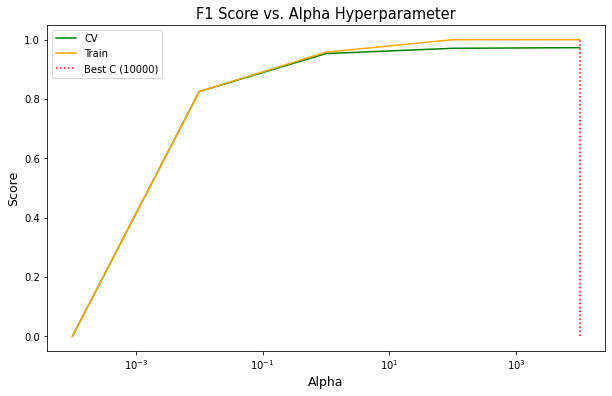

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.title('F1 Score vs. Alpha Hyperparameter', fontsize=14.5)
plt.plot(C_value[0]['C'], mean_test_score, color='green', label='CV')
plt.plot(C_value[0]['C'], mean_train_score, color='orange', label='Train')
plt.vlines(lr_grid_cv.best_params_['C'], ymin=0, ymax=1, 
           label='Best C ({})'.format(lr_grid_cv.best_params_['C']),
           linestyles='dotted', color='red')
plt.xscale('log')
plt.ylabel('Score', fontsize=12.5)
plt.xlabel('Alpha', fontsize=12.5)
plt.legend(loc='upper left')
fig.show()

##### Confusion Matrix

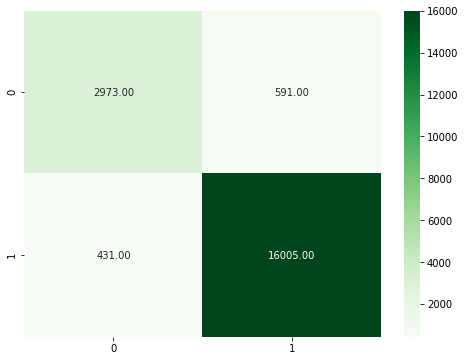

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='0.2f', cmap='Greens')
plt.show()

# 5. Conclusion

In [ ]:
x = PrettyTable()

x.field_names = ['MODEL NAME', 'Best Parameter', 'F1 SCORE']

x.add_row(['Support Vector Machine', '0.001', '96.1'])
x.add_row(['L2 Logistic Regression', '10000', '96.6'])
x.add_row(['L1 Logistic Regression (Feature Selection)', '10000', '97.0'])
print(x)

+--------------------------------------------+----------------+----------+
|                 MODEL NAME                 | Best Parameter | F1 SCORE |
+--------------------------------------------+----------------+----------+
|           Support Vector Machine           |     0.001      |   96.1   |
|           L2 Logistic Regression           |     10000      |   96.6   |
| L1 Logistic Regression (Feature Selection) |     10000      |   97.0   |
+--------------------------------------------+----------------+----------+
